# AdaBoost – Wine Quality (binaire)

Ce notebook applique **AdaBoost** selon le cahier des charges :
- Boosting adaptatif : ensemble d'apprenants faibles
- Mentionné dans le cahier : Gradient Boosting "souvent plus précis qu'AdaBoost"
- Comparaison directe avec Gradient Boosting
- Évaluation avec Accuracy, F1-score, importance des features
- Suivi avec MLflow

## 1. Imports et configuration

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
# Racine du projet (dossier contenant src/ et dataset/)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project.")
from preprocessing import load_data, clean_data, scale_features, split_data
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///c:/Users/pc/Desktop/ML-project/classification/mlflow.db")
mlflow.set_experiment("wine-quality-adaboost")

<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/classification/mlruns/7', creation_time=1771082994348, experiment_id='7', last_update_time=1771082994348, lifecycle_stage='active', name='wine-quality-adaboost', tags={}>

## 2. Chargement et preprocessing

In [8]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

df["quality_binary"] = (df["quality"] >= 6).astype(int)

X = df.drop(columns=["quality", "quality_binary"])
y = df["quality_binary"]
feature_names = X.columns.tolist()

X_scaled, scaler = scale_features(X)
X_train, X_test, y_train, y_test = split_data(X_scaled, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 1087, Test: 272


## 3. Entraînement du modèle

In [9]:
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
ada = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.739
F1-score: 0.753
Precision: 0.755
Recall: 0.750

Matrice de confusion:
[[ 93  35]
 [ 36 108]]


## 4. Importance des features

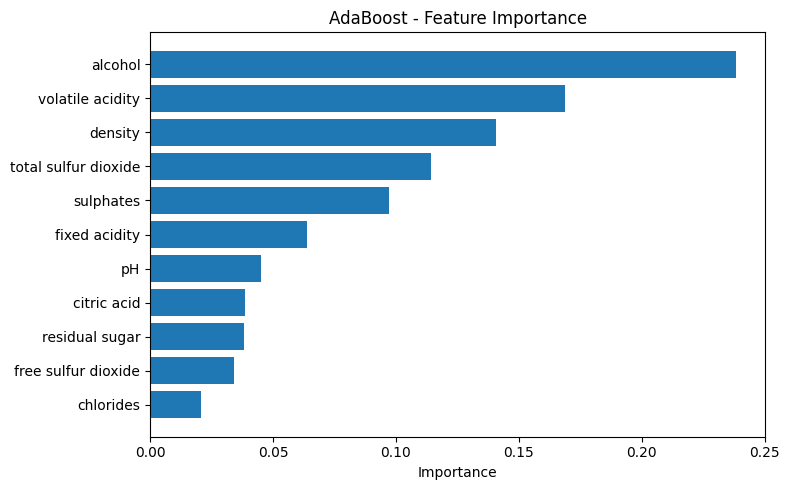

In [10]:
importance = ada.feature_importances_
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(8, 5))
plt.barh(range(len(importance)), importance[indices])
plt.yticks(range(len(importance)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.title('AdaBoost - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('adaboost_feature_importance.png')
plt.show()

## 5. Matrice de confusion

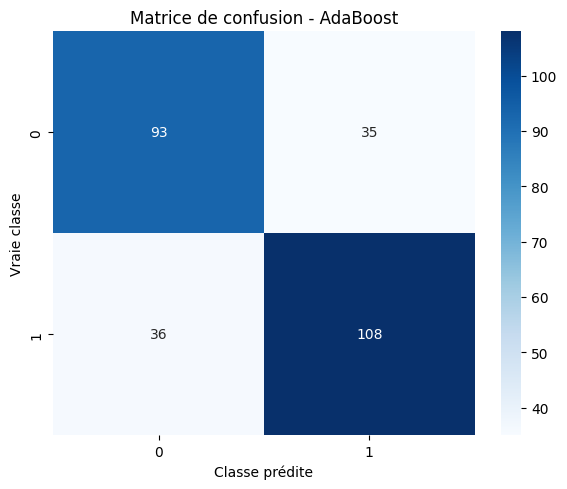

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - AdaBoost')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.savefig('adaboost_confusion_matrix.png')
plt.show()

## 6. MLflow tracking

In [12]:
with mlflow.start_run(run_name="AdaBoost_binary"):
    mlflow.log_param("n_estimators", ada.n_estimators)
    mlflow.log_param("base_estimator", "DecisionTree(max_depth=1)")
    mlflow.log_metric("accuracy", float(acc))
    mlflow.log_metric("f1_score", float(f1))
    mlflow.log_metric("precision", float(precision))
    mlflow.log_metric("recall", float(recall))
    mlflow.log_artifact('adaboost_confusion_matrix.png')
    mlflow.log_artifact('adaboost_feature_importance.png')
    mlflow.sklearn.log_model(ada, "adaboost_model")
    print("MLflow run terminé")

2026/02/14 17:11:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


MLflow run terminé
